# Predicción de la tasa de anillamiento de aves
**Autores:** DANIELLE MAREE MCKENNEY & MARIA JOSÉ CASTRO PÉREZ   &nbsp;&nbsp;&nbsp; **Última modificación:** 29/01/2024

In [2]:
#Importación de librerias

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Lectura del dataset

### 1.1 Definición de funciones auxiliares

In [3]:
# definimos una función para quedarnos solo con las columnas relevantes para nuestro análisis
def cleanRawData(rawData, relevantColumns):
    # returns a dataframe with only the relevent columns and with invalid location entries removed
    df = rawData.filter(items=relevantColumns)
    df = df[(df['decimalLatitude'] != 0) & (df['decimalLongitude'] != 0)]
    return df

# definimos una función para llenar los valores faltantes 
def fillInCounts0(data, dateCombination):
    # Fill in count=0 in the grouped summary
    # Get all unique combinations of the date combination
    existing_combinations = data[dateCombination].drop_duplicates()

    # Create a DataFrame with all unique species
    all_species_combinations = pd.DataFrame({'species': data['species'].unique()})

    # Cross join (cartesian product) to get all combinations of 'species', 'eventDate', and 'locality'
    all_combinations = pd.merge(existing_combinations.assign(key=1), all_species_combinations.assign(key=1), on='key').drop('key', axis=1)

    # Merge with the original DataFrame to get counts
    on = dateCombination.append('species')
    result_df = pd.merge(all_combinations, data, on=on, how='left').fillna(0)
    return result_df

### 1.2 Tratamiento Dataset 
Después de leer el conjunto de datos, lo filtramos para quedarnos con las columnas relevantes. Las demás incluyen datos redundantes, como información sobre la taxonomía de las especies o detalles sobre la base de datos. 
Podemos observar, por ejemplo, que no hay datos faltantes y que hay una gran cantidad de localidades diferentes utilizadas en este conjunto de datos.
Dado que cada fila corresponde a un ave anillada, tendremos que remodelar estos datos para poder extraer una tasa para una localidad dada.

In [4]:
#Lectura del dataset y selección de las columnas relevantes
DATOS = pd.read_csv('./dataset.csv', sep="\t", on_bad_lines="warn")
relevantColumns = ['species','locality','decimalLatitude', 'decimalLongitude', 'eventDate', 'stateProvince']

df = cleanRawData(DATOS, relevantColumns)

In [4]:
print(df.info())
print(df.describe())
print(df.shape)
print(df.columns)
# Number of unique locations
print("Information about localities")
print(df['locality'].value_counts())
# No data is missing in the relevant columns:
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 751856 entries, 0 to 753578
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   species           751856 non-null  object 
 1   locality          751856 non-null  object 
 2   decimalLatitude   751856 non-null  float64
 3   decimalLongitude  751856 non-null  float64
 4   eventDate         751856 non-null  object 
 5   stateProvince     751856 non-null  object 
dtypes: float64(2), object(4)
memory usage: 40.2+ MB
None
       decimalLatitude  decimalLongitude
count    751856.000000     751856.000000
mean         39.645485         -2.164332
std           2.127383          3.320939
min          27.750000        -39.290560
25%          37.816670         -4.566670
50%          39.866670         -1.650000
75%          41.466670          0.033330
max          43.783330          4.833330
(751856, 6)
Index(['species', 'locality', 'decimalLatitude', 'decimalLongitude',
   

## 2.Agrupaciones del dataset

### 2.1 Agrupaciones por mes

Los datos de anillamiento de aves no se recopilaron todos los días, por lo que, con el fin de tener datos suficientes para crear una serie temporal, necesitamos agrupar las observaciones.

In [8]:

# Group by 'species', 'eventDate', and 'locality' and count the rows in each group
grouped_eventDate_df = df.groupby(['species', 'eventDate', 'locality']).size().reset_index(name='count')
# Fill in count=0 on days where a locality was visited but no entry was made for that species
grouped_eventDate_df = fillInCounts0(grouped_eventDate_df, ['eventDate', 'locality'])

grouped_eventDate_df['eventDate'] = pd.to_datetime(grouped_eventDate_df['eventDate'])

grouped_eventDate_df['month'] = grouped_eventDate_df['eventDate'].dt.month
grouped_eventDate_df['year'] = grouped_eventDate_df['eventDate'].dt.year

grouped_month_df = grouped_eventDate_df.groupby(['species', 'month', 'year', 'locality']).sum('count').reset_index()
grouped_month_df = grouped_month_df.filter(items=['species', 'month', 'year', 'locality', 'count', 'stateProvince'])

grouped_year_df = grouped_eventDate_df.groupby(['species', 'year', 'locality']).sum('count').reset_index()
grouped_year_df = grouped_year_df.filter(items=['species', 'year', 'locality', 'count','stateProvince'])



### 2.2. Conteo de especies por año

Con visualizaciones, podemos observar que ciertas especies, ciertas ubicaciones y ciertos años tienen más datos disponibles. Utilizaremos esta información para tomar decisiones sobre qué tipo de ave y para qué ubicación crearemos un modelo de series temporales.

In [ ]:
# Crear una paleta de colores única basada en todas las especies
paleta_colores = sns.color_palette('husl', n_colors=len(grouped_year_df['species'].unique()))
# Mapear cada especie a un color específico
especies_a_colores = dict(zip(grouped_year_df['species'].unique(), paleta_colores))

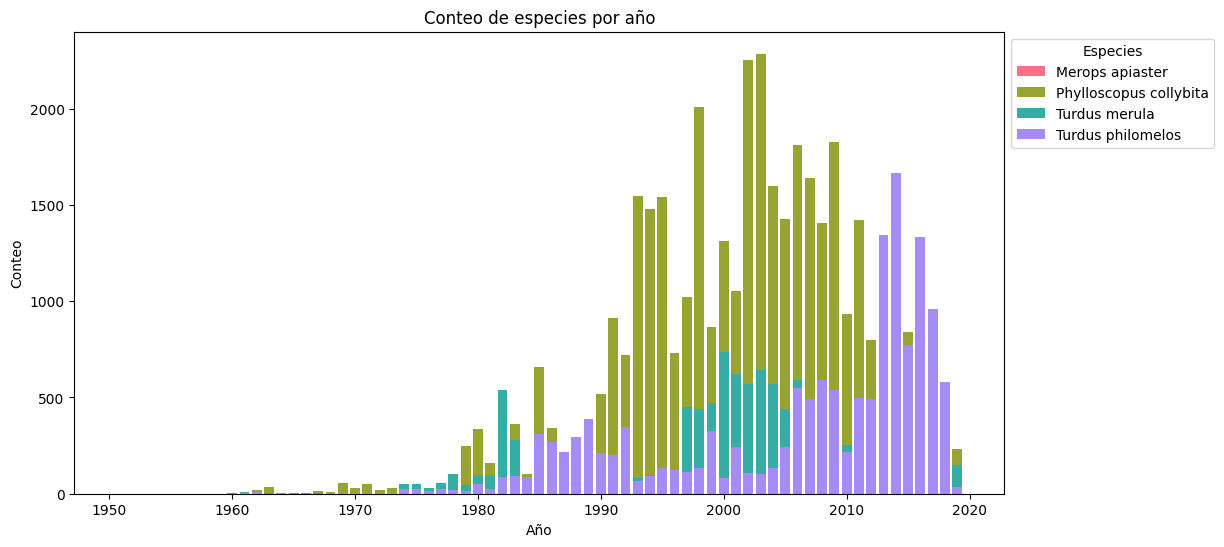

In [10]:
### 2.1. Conteo de especies por año

# Conteo de especies por año
plt.figure(figsize=(12, 6))
for species, data in grouped_year_df.groupby('species'):
    plt.bar(data['year'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de especies por año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

### 2.3. Estacionalidad - Conteo de especies por meses

Con la siguiente visualización, observamos que ciertas especies solo están presentes en ciertos momentos del año en España. Esto significa que nuestra serie temporal tendrá un componente estacional anual.


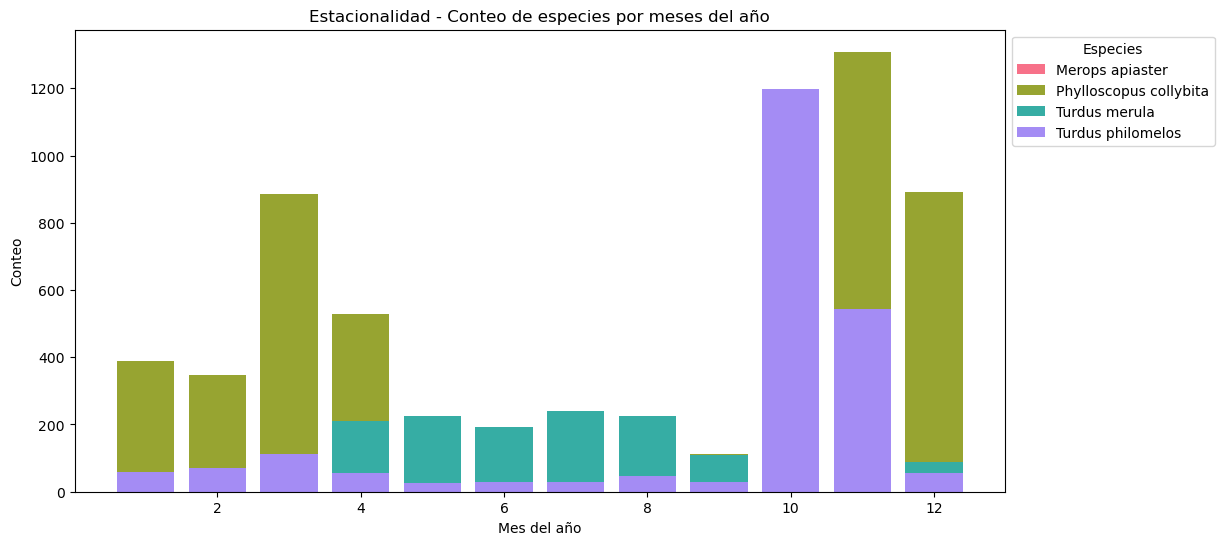

In [10]:
### 2.3. Estacionalidad - Conteo de especies por meses
plt.figure(figsize=(12, 6))
for species, data in grouped_month_df.groupby('species'):
    plt.bar(data['month'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Mes del año')
plt.ylabel('Conteo')
plt.title('Estacionalidad - Conteo de especies por meses del año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

## 3.Phylloscopus collybita: Mosquitero común
### 3.1. Conteo de Mosquitero común por año
### 3.2. Conteo de Mosquitero común por provincia

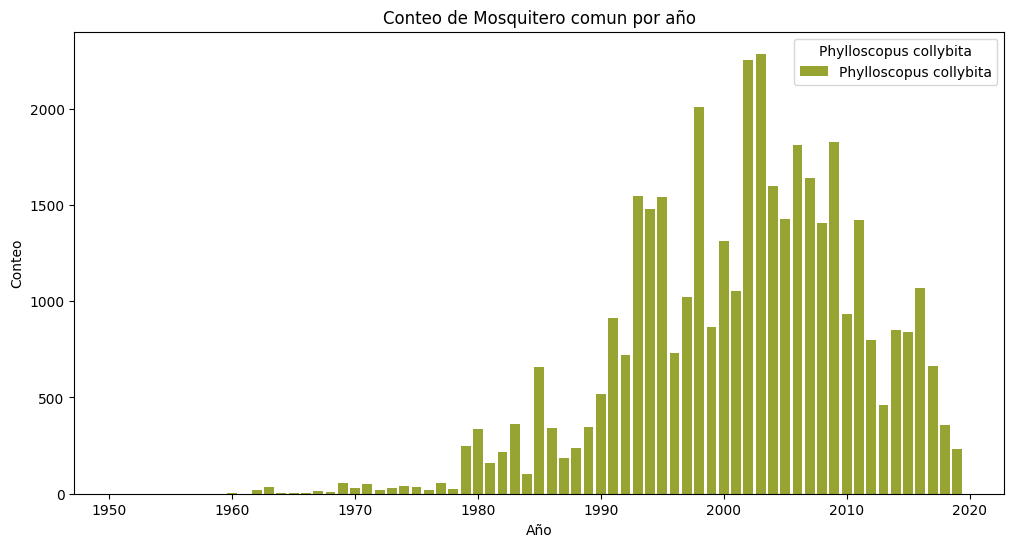

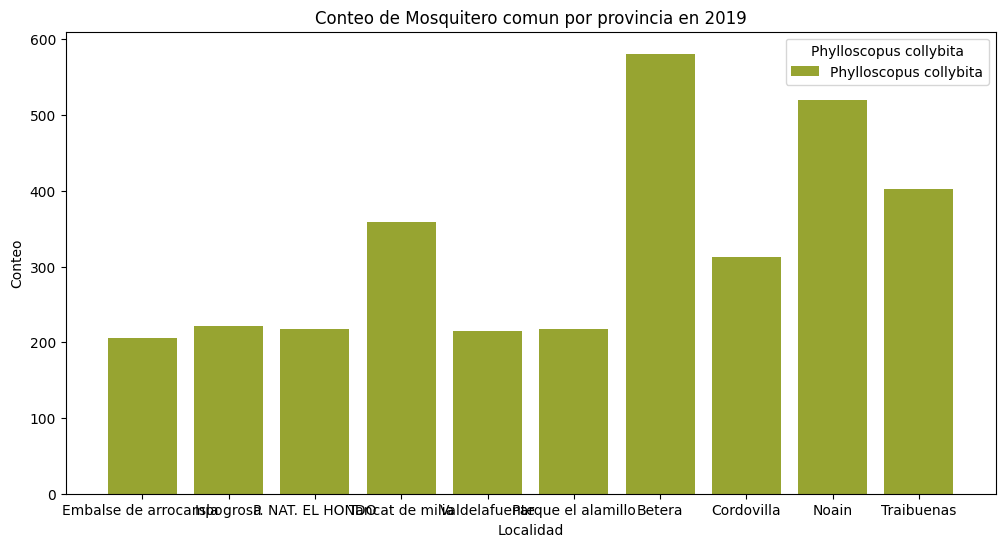

In [35]:
#Estudio de Phylloscopus collybita ("Mosquitero común")
especie = 'Phylloscopus collybita'
nombre_comun = 'Mosquitero comun'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mosquitero por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

rango_anos = range(2018, 2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

### 3.2. Conteo de Mosquitero común por provincia
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['locality'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Localidad')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 4.Predicción series temporales

Debido a que las series temporales no pueden manejar predicciones espacio-temporales, seleccionamos una especie y una ubicación para modelar. Para seleccionar la ubicación, queremos asegurarnos de que tenga una buena cantidad de datos a lo largo de varios años. La siguiente visualización nos ayuda con esta decisión.

### 4.1. Optimización de parámetros

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_74220/336414536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_month_df_top_loc['date'] = pd.to_datetime(grouped_month_df_top_loc[['year', 'month']].assign(DAY=1))


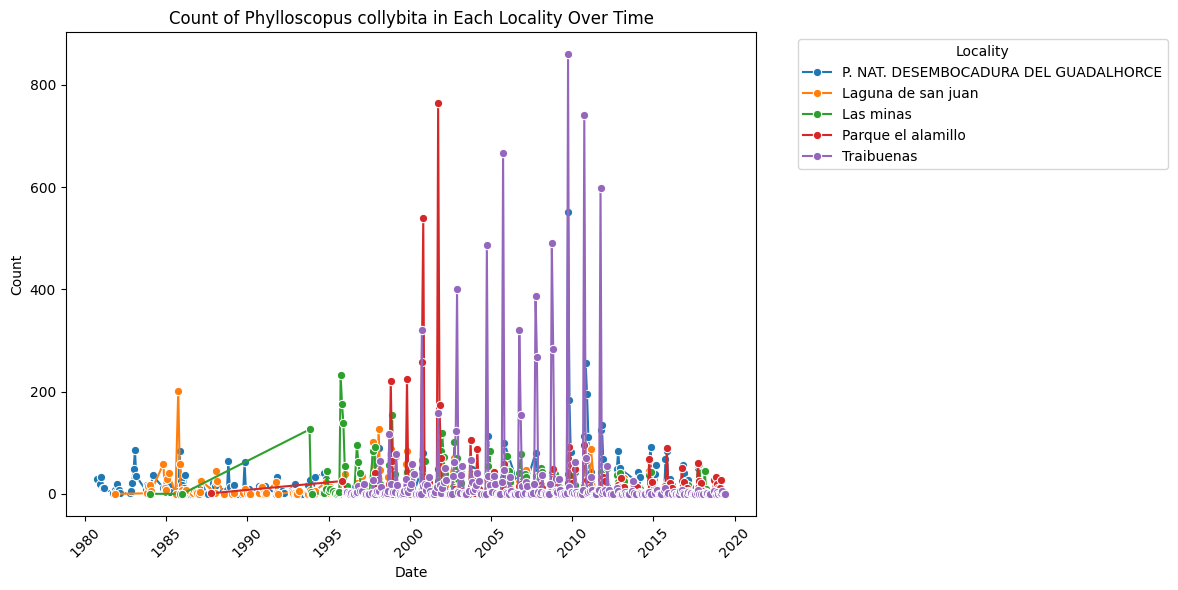

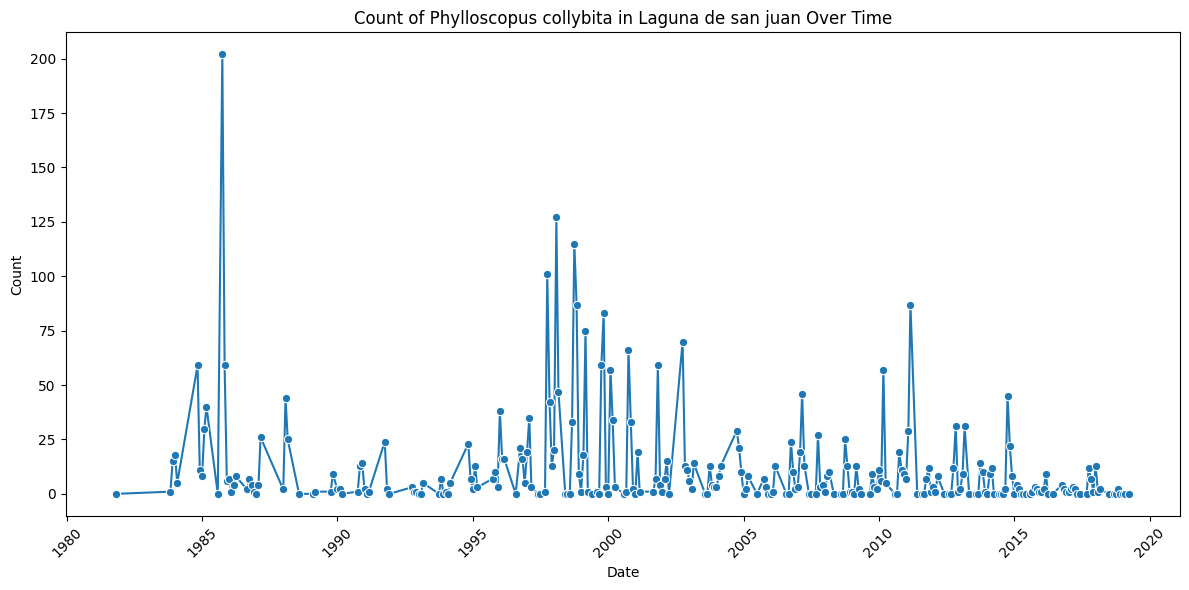

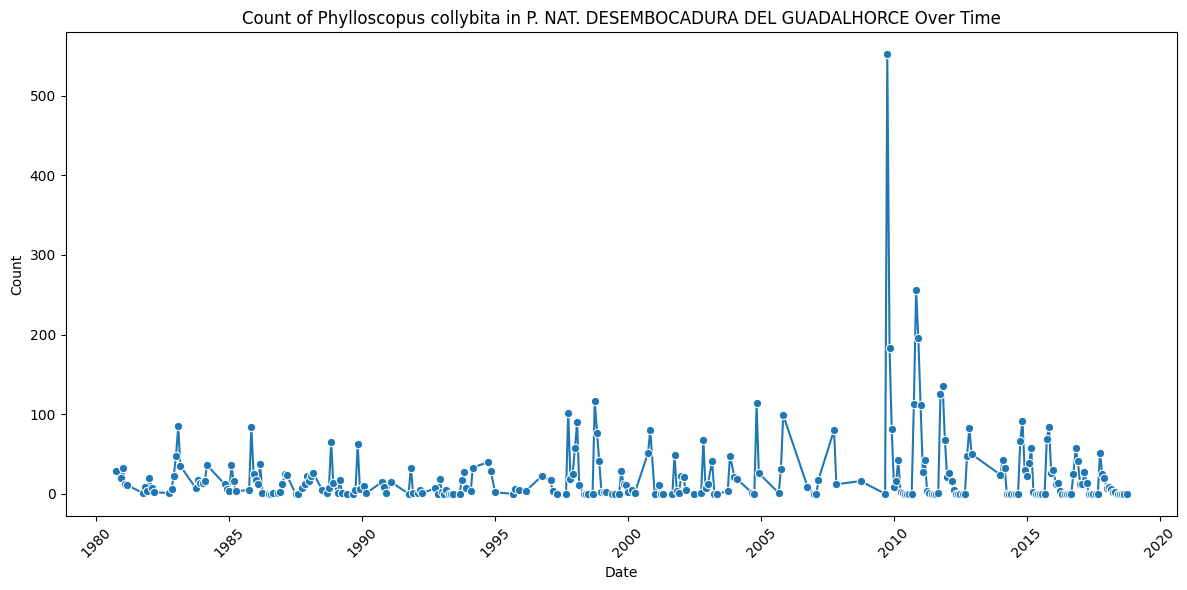

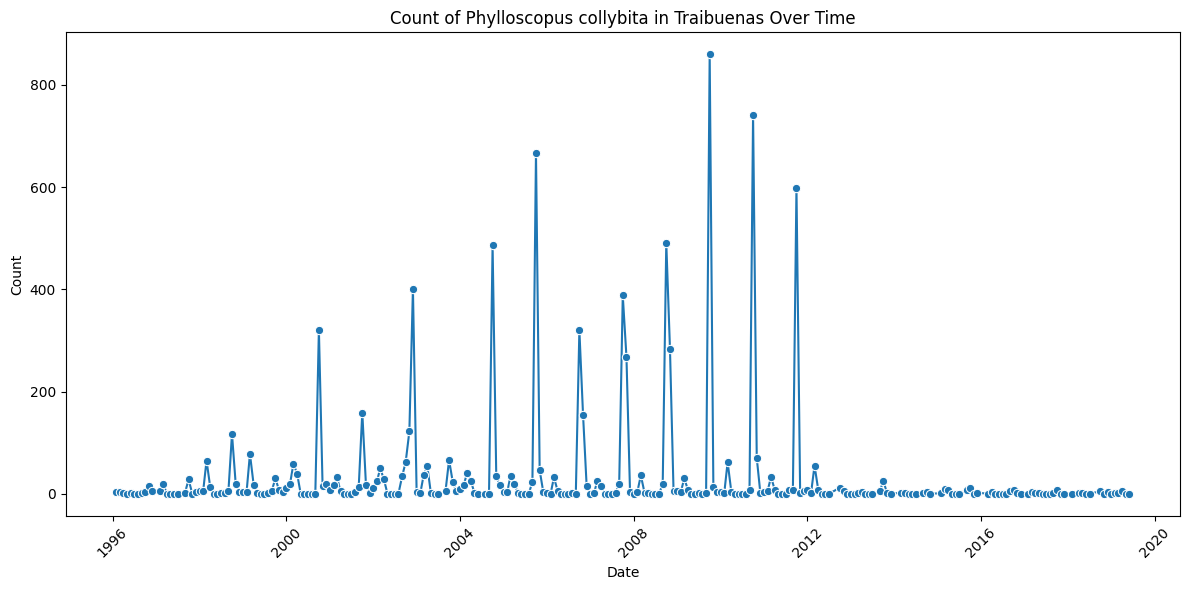

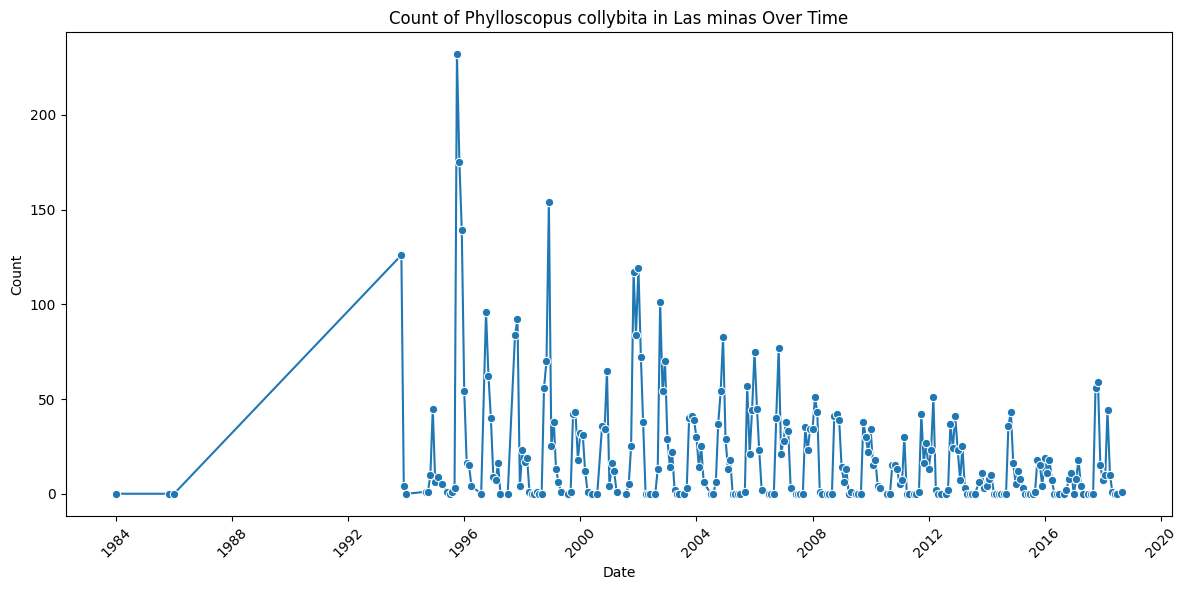

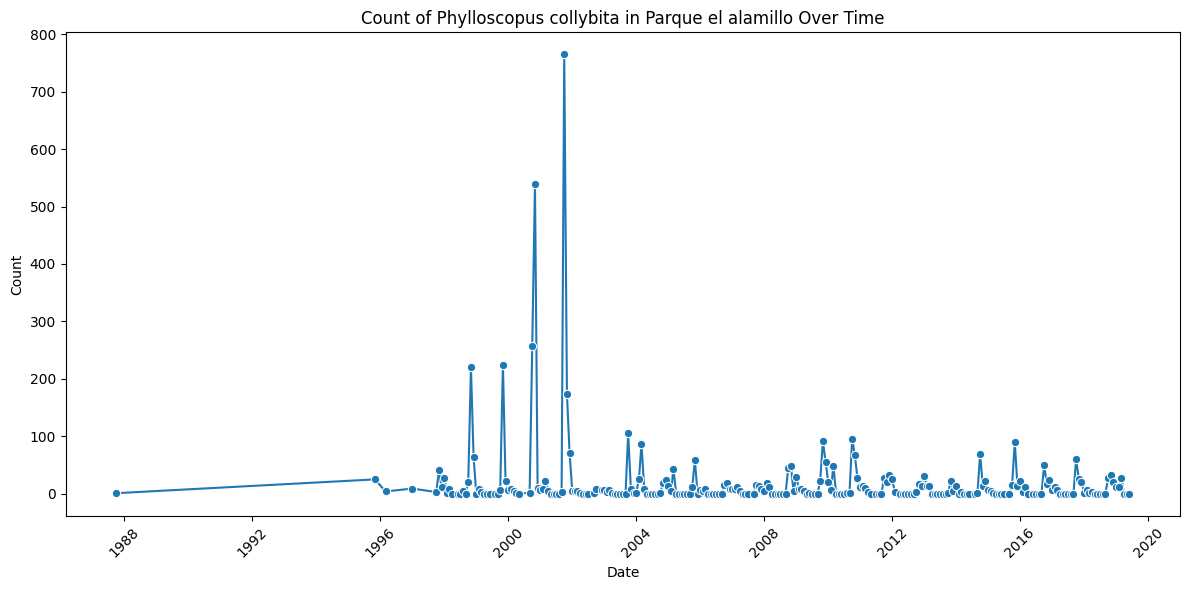

Locality with the most data: Laguna de san juan


In [12]:
species_to_visualize = "Phylloscopus collybita"
species_data_month = grouped_month_df[grouped_month_df['species'] == species_to_visualize]

locality_counts = species_data_month['locality'].value_counts()

# Get the 5 most common localities
top_localities = locality_counts.nlargest(5)

# List the names and counts of the top localities
grouped_month_df_top_loc = species_data_month[species_data_month['locality'].isin(top_localities.index)]
grouped_month_df_top_loc['date'] = pd.to_datetime(grouped_month_df_top_loc[['year', 'month']].assign(DAY=1))

# Filter data for the selected species
species_data = grouped_month_df_top_loc[grouped_month_df_top_loc['species'] == species_to_visualize]

# Plot the count in each location over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='count', hue='locality', data=species_data, marker='o')
plt.title(f'Count of {species_to_visualize} in Each Locality Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Locality', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

for cld in top_localities.index:
    chosen_locality_data = species_data[species_data['locality'] == cld]

    # Plot the count for the chosen locality
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='count', data=chosen_locality_data, marker='o')
    plt.title(f'Count of {species_to_visualize} in {chosen_locality_data["locality"].iloc[0]} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

print(f"Locality with the most data: {top_localities.idxmax()}")
max_locality = top_localities.idxmax()

### 4.2. Definición del modelo
Crearemos un modelo para el mosquitero común localidad en la localidad Parque el alamillo. El conjunto de datos siguiente es lo que alimentaremos en nuestro modelo:

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_74220/182113978.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))


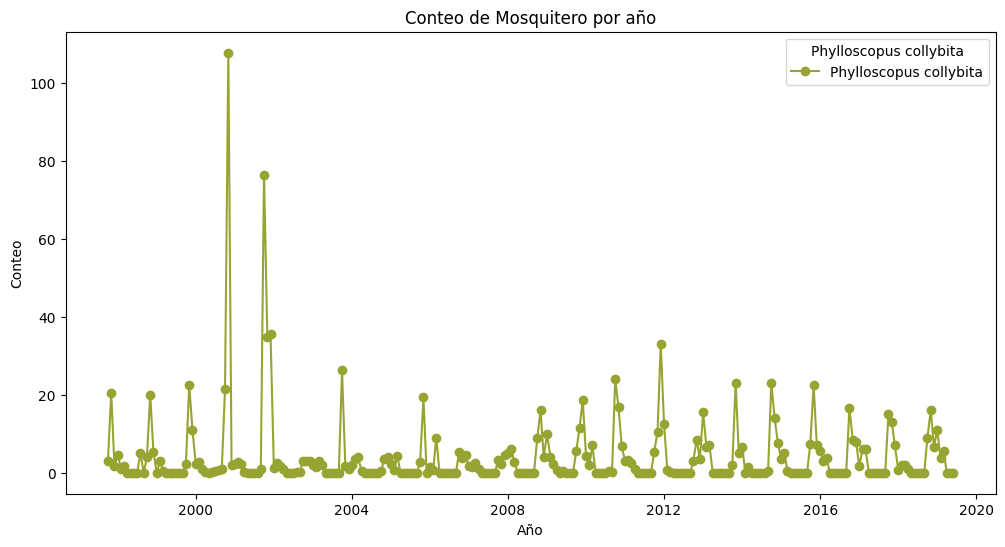

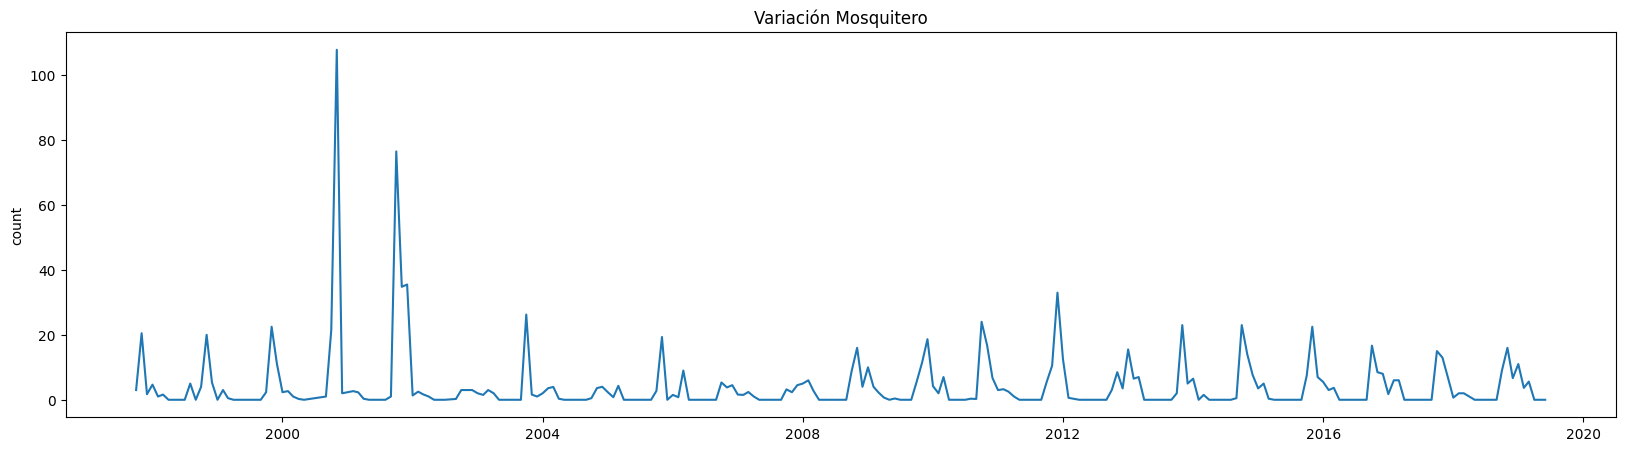

In [13]:
# Especificar la especie, nombre común y localidad
especie = 'Phylloscopus collybita'
nombre_comun = 'Mosquitero'
locality = "Parque el alamillo"

# Obtener la tasa promedio de anillado para esta especie en esta localidad
grouped_month_df_mean = grouped_eventDate_df.groupby(['species', 'month', 'year', 'locality']).mean('count').reset_index()
grouped_month_df_mean = grouped_month_df_mean.filter(items=['species', 'month', 'year', 'locality', 'count'])

# Filtrar el DataFrame para la especie y localidad específicas
df_filtrado = grouped_month_df_mean[(grouped_month_df_mean['species'] == especie) & (grouped_month_df_mean['locality'] == locality)]
df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))
df_filtrado = df_filtrado.sort_values(by='date')
df_filtrado = df_filtrado[df_filtrado['date'] > '1997-01-01']

# Preparar los datos para el análisis de series temporales
datos = df_filtrado.sort_values(by='date')
datos = datos.drop(['species', 'locality'], axis=1)
datos = datos.set_index('date')

# Definir la frecuencia mensual
start_date = datos.index.min()
end_date = datos.index.max()
new_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
new_datos = pd.DataFrame(index=new_dates)
datos = new_datos.merge(datos, how='left', left_index=True, right_index=True)

# Interpolar los valores faltantes por la media lineal
datos['count'].interpolate(method='linear', limit_direction='both', inplace=True)

# Visualizar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(datos.index, datos['count'], marker='o', color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' + nombre_comun + ' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
plt.show()

# Función para trazar series temporales con opciones de filtro
def trazar(datos, rotacion=0, desde=None, hasta=None, figsize=(20, 5), title=''):
    plt.figure(figsize=figsize)
    
    # Filtrar por rango de fechas si se especifica
    if desde is None:
        desde = datos.index.min()
    else:
        desde = pd.to_datetime(desde, format='%d/%m/%Y')
    if hasta is None:
        hasta = datos.index.max()
    else:
        hasta = pd.to_datetime(hasta, format='%d/%m/%Y')
    
    datos = datos[(datos.index >= desde) & (datos.index <= hasta)]
    
    # Visualizar la serie temporal
    sns.lineplot(data=datos)
    plt.xticks(rotation=rotacion)
    plt.title(title)
    plt.show()

# Utilizar la función para visualizar la variación de la especie
trazar(datos['count'], title="Variación Mosquitero")


### 4.3.Suavizado de datos
Podemos observar que a principios de la década de 2000 se anillaron muchas más aves que en otros años, por lo que suavizamos estos años atípicos:

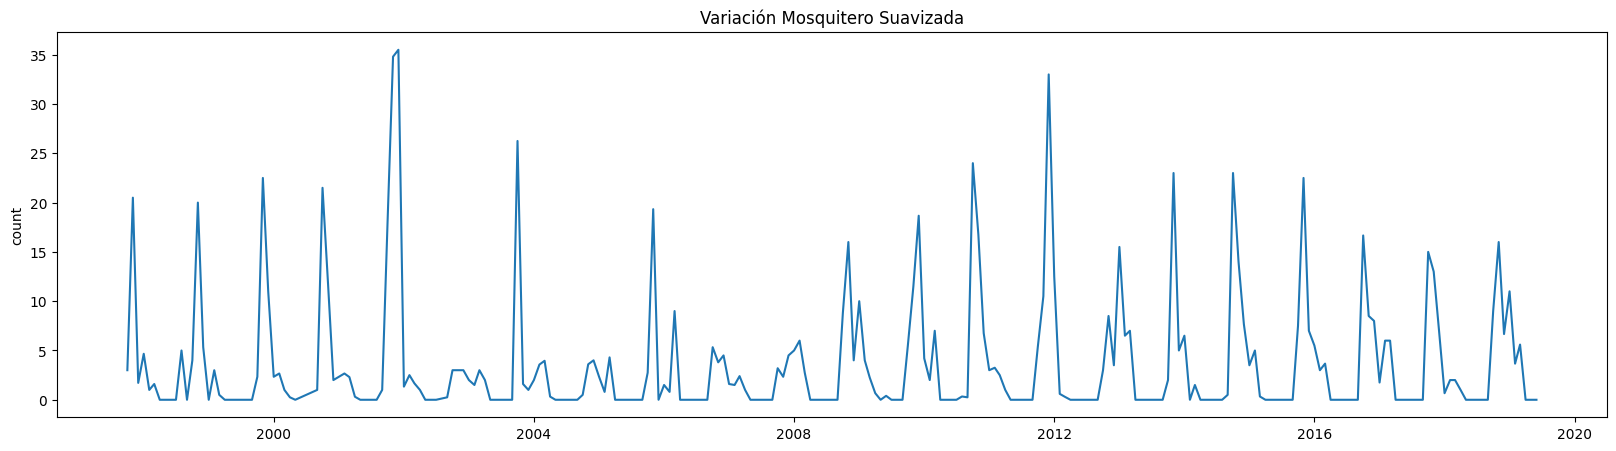

In [14]:
# Smooth the data; interpolate on data whose zscore is >= umbral_zscore
def suavizar_outliers(datos, umbral_zscore=3):
    # Crear un DataFrame para manipulación conveniente
    df = pd.DataFrame({'serie': datos})   
    
    # Calcular y almacenar los valores Z-score
    df['zscore'] = stats.zscore(datos).abs()
    
    # Establecer a NaN los valores que superan el umbral Z-score
    df.loc[df['zscore'] >= umbral_zscore, 'serie'] = np.nan
    
    # Interpolar los valores faltantes de la serie
    df['serie'] = df['serie'].interpolate(method='linear')
    
    # Devolver la serie suavizada sin outliers
    return df['serie']

# Copiar los datos originales antes de suavizar outliers
datos_smoothed = datos.copy()

# Aplicar la función de suavizado de outliers a la columna 'count'
datos_smoothed['count'] = suavizar_outliers(datos['count'], 4)

# Llamar a la función 'trazar' para visualizar la serie suavizada
trazar(datos_smoothed['count'], title="Variación Mosquitero Suavizada")



### 4.3. Selección de Hyperparámetros
Utilizamos los gráficos de autocorrelación y autocorrelación parcial para determinar el intervalo de parámetros que debemos introducir en un GridSearch. Los picos en el PACF indican valores p potencialmente buenos (orden de autoregresión) y los picos en el ACF indican valores q potencialmente buenos (orden de media móvil). Sin embargo, debido a la limitación de los recursos informáticos, la búsqueda fue limitada.

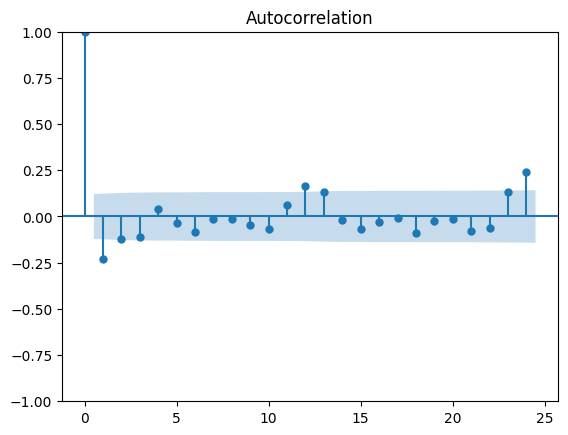

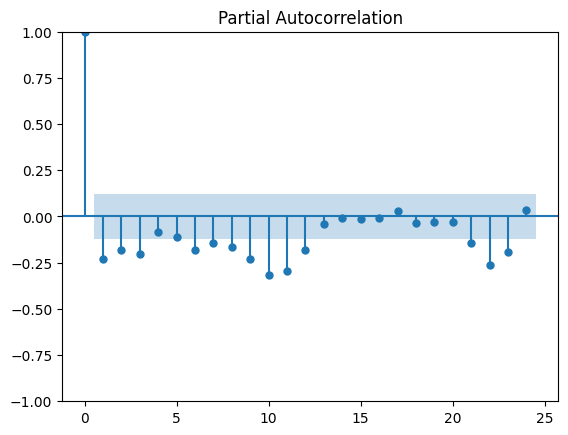

In [18]:
# Determine the order of differencing
diff = datos_smoothed['count'].diff().dropna()

# Plot ACF and PACF to help determine the seasonal order
plot_acf(diff, lags=24)
plot_pacf(diff, lags=24)
plt.show()


In [ ]:
# optimizacion de parámetros

# Parámetros a probar
p_values = [1, 2]
d_values = [0, 1]
q_values = [1, 2]
P_values = [1, 2]
D_values = [0, 1]
Q_values = [1, 2]

# Almacena los resultados y los criterios de evaluación
best_aic = np.inf
best_order = None
best_seasonal_order = None

# Grid Search
# Itera sobre todas las combinaciones posibles
for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        # Ajusta el modelo SARIMA
        order = (p, d, q)
        seasonal_order = (P, D, Q, 12)  # La estacionalidad asumida es anual
        sarima_model = SARIMAX(datos_smoothed['count'], order=order, seasonal_order=seasonal_order)
        sarima_results = sarima_model.fit()

        # Almacena el modelo si mejora el criterio de evaluación (menor AIC en este caso)
        if sarima_results.aic < best_aic:
            best_aic = sarima_results.aic
            best_order = order
            best_seasonal_order = seasonal_order

    except Exception as e:
        continue


In [27]:
# Muestra los mejores parámetros encontrados
print(f"Best SARIMA Order: {best_order}")
print(f"Best SARIMA Seasonal Order: {best_seasonal_order}")

# Ajusta el modelo SARIMA con los mejores parámetros
best_sarima_model = SARIMAX(datos_smoothed['count'], order=best_order, seasonal_order=best_seasonal_order)


Best SARIMA Order: (1, 0, 1)
Best SARIMA Seasonal Order: (1, 1, 1, 12)


### 4.4. Obtención de la serie temporal

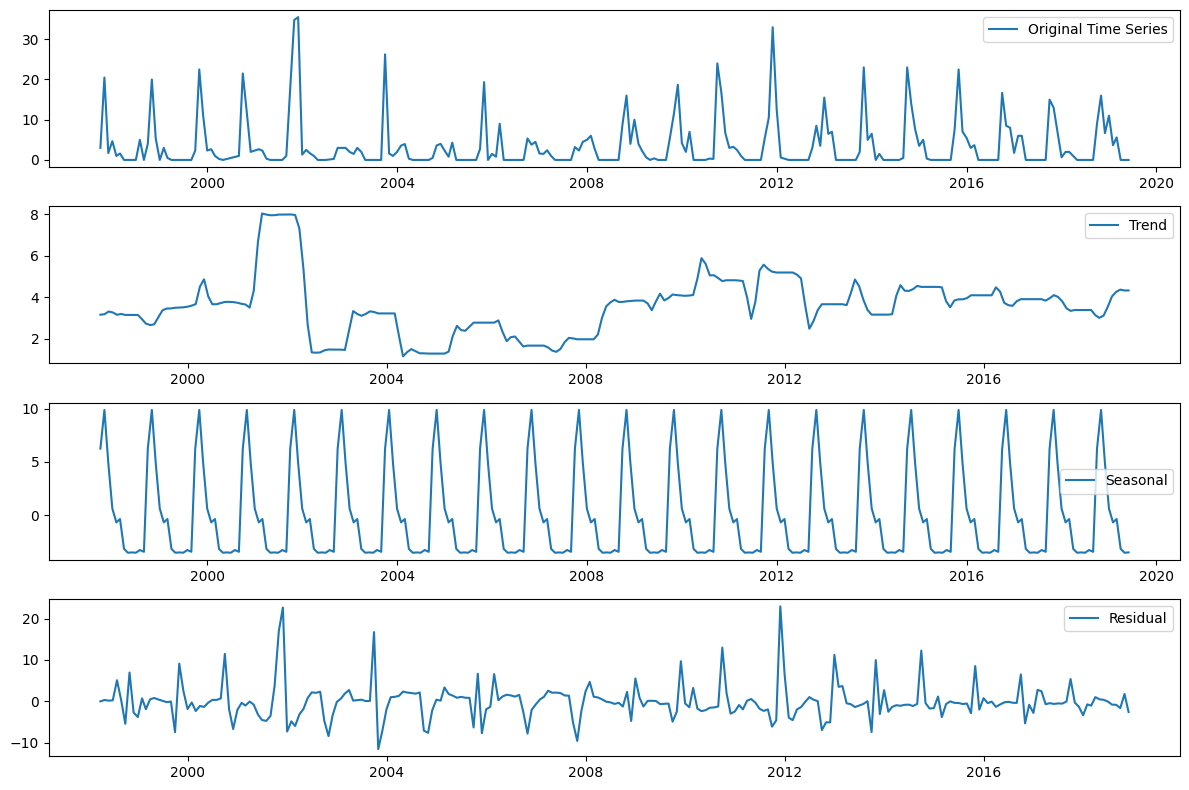

In [28]:
### 4.4. Obtención de la serie temporal

# # Perform seasonal decomposition
result = seasonal_decompose(datos_smoothed['count'], model='additive', period=12)

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(datos_smoothed['count'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01349D+00    |proj g|=  5.85039D-02

At iterate    5    f=  2.90842D+00    |proj g|=  3.99209D-02


 This problem is unconstrained.



At iterate   10    f=  2.90249D+00    |proj g|=  4.13307D-03

At iterate   15    f=  2.90163D+00    |proj g|=  7.84472D-03

At iterate   20    f=  2.90114D+00    |proj g|=  1.40009D-03

At iterate   25    f=  2.90109D+00    |proj g|=  2.16242D-04

At iterate   30    f=  2.90108D+00    |proj g|=  2.31824D-04

At iterate   35    f=  2.90108D+00    |proj g|=  3.62492D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     44      1     0     0   2.541D-05   2.901D+00
  F =   2.9010815846887610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


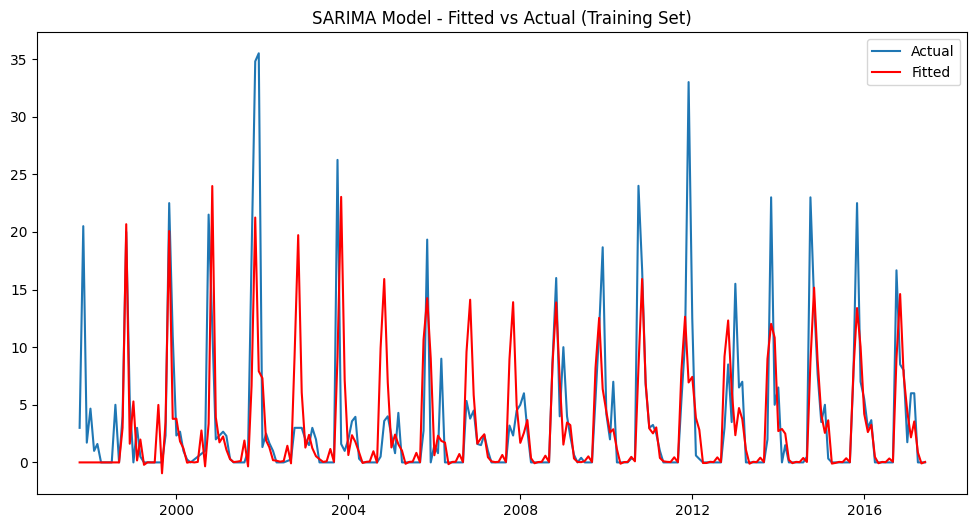

In [29]:
# Definir el tamaño del conjunto de prueba
test_size = 24  # Dos años de datos de prueba - 5% del dataset

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data = datos_smoothed[:-test_size]
test_data = datos_smoothed[-test_size:]

# Establecer el orden del modelo SARIMA
order = best_order  # Reemplazar con valores apropiados basados en el análisis de ACF y PACF
seasonal_order = best_seasonal_order  # Suponiendo una estacionalidad anual

# Crear y ajustar el modelo SARIMA en los datos de entrenamiento
sarima_model = SARIMAX(train_data['count'], order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Graficar valores pronosticados vs reales para el conjunto de entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(train_data['count'], label='Actual')
plt.plot(sarima_results.fittedvalues, label='Fitted', color='red')
plt.title('SARIMA Model - Fitted vs Actual (Training Set)')
plt.legend()
plt.show()

# Graficar valores pronosticados vs reales para el conjunto de


## 4.5. Evaluación del Modelo

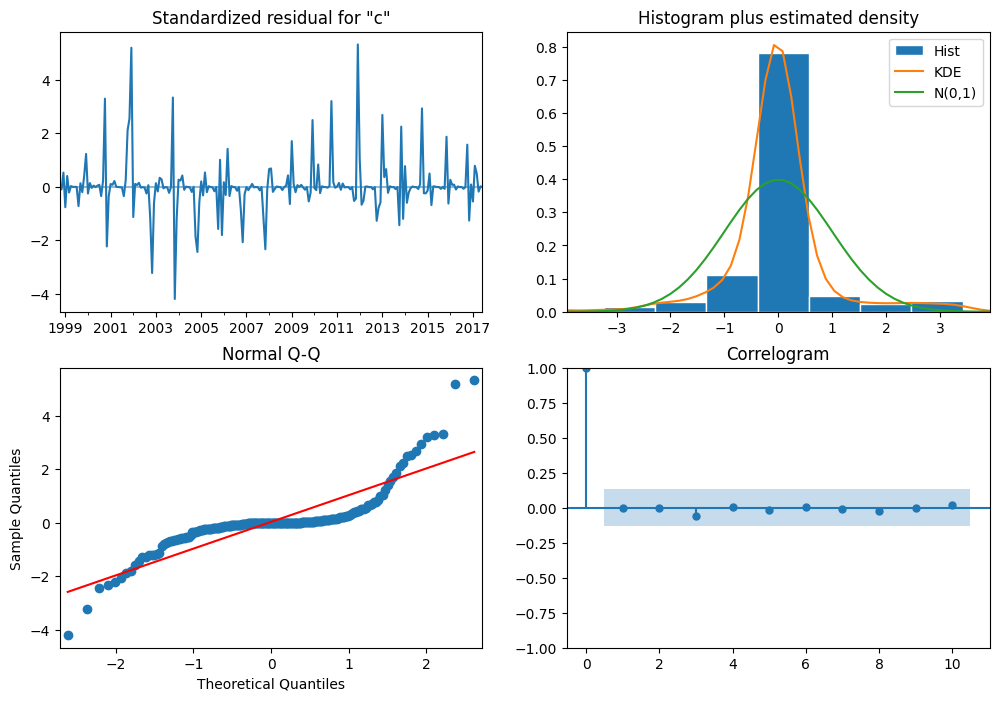

Mean Absolute Error: 1.26
Mean Squared Error: 4.94
Root Mean Squared Error: 2.22


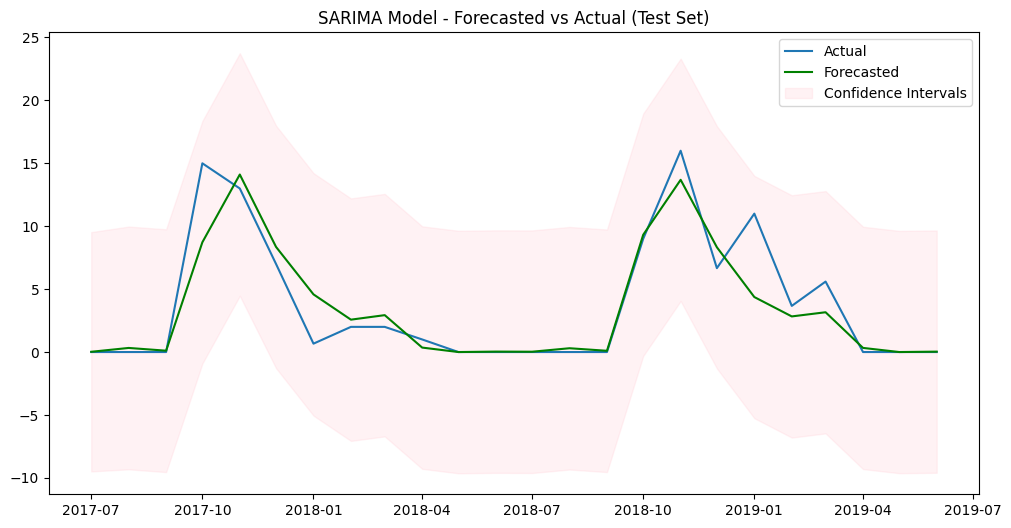

In [36]:
# Visualización de diagnósticos del modelo SARIMA
sarima_results.plot_diagnostics(figsize= (12, 8))
plt.show()

# Pronóstico en el conjunto de prueba
forecast = sarima_results.get_forecast(steps=test_size)

# Extracción de valores reales del conjunto de prueba
actual_values = test_data['count']

# Extracción de valores pronosticados y intervalos de confianza
forecasted_values = forecast.predicted_mean
ci_lower = forecast.conf_int()['lower count']
ci_upper = forecast.conf_int()['upper count']

# Cálculo de métricas de evaluación
mae = mean_absolute_error(actual_values, forecasted_values)
mse = mean_squared_error(actual_values, forecasted_values)
rmse = np.sqrt(mse)

# Impresión de las métricas de evaluación
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

# Visualización del pronóstico con intervalos de confianza
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual')
plt.plot(forecasted_values, label='Forecasted', color='green')
plt.fill_between(actual_values.index, ci_lower, ci_upper, color='pink', alpha=0.2, label='Confidence Intervals')
plt.title('SARIMA Model - Forecasted vs Actual (Test Set)')
plt.legend()
plt.show()



## 5. Ejemplo de proceso gaussiano 

Aunque no aplicamos un proceso gaussiano a nuestro conjunto de datos, el siguiente código contiene un ejemplo de aplicación de un regresor de proceso gaussiano a un conjunto de datos ficticio con fines experimentales.

/Users/daniellemckenney/Programming/erasmusCourses/ML/mlProjectsBirbs/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_74220/2067490797.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_new[:, 0], X_new[:, 1], c=y_pred[:, 0], cmap='viridis', marker='x', edgecolors='k', s=200, linewidth=2, zorder=10)


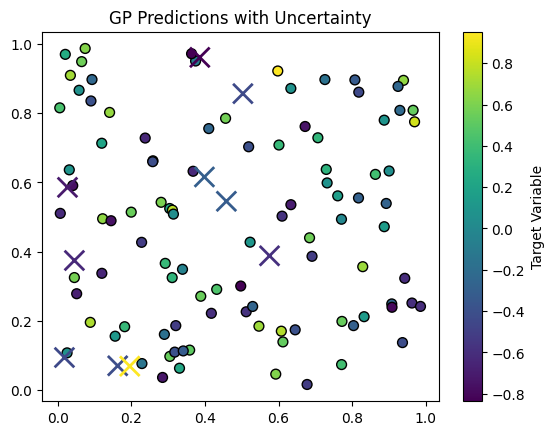

In [34]:
# Generate synthetic spatiotemporal data
np.random.seed(42)
X = np.random.rand(100, 2)  # Assuming 2D spatial coordinates
t = np.linspace(0, 1, 100)[:, np.newaxis]  # Time
y = np.sin(2 * np.pi * t) * np.exp(-X[:, 0]) + np.random.randn(100, 1) * 0.1  # Synthetic target variable

# Combine spatial and temporal features
X_combined = np.hstack((X, t))

# Specify the kernel (RBF for spatial, Matern for temporal)
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Create and fit Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_combined, y)

# Predict at new spatiotemporal points
X_new = np.random.rand(10, 3)  # New test points
y_pred, sigma = gp.predict(X_new, return_std=True)

# Visualize predictions
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0], cmap='viridis', marker='o', edgecolors='k', s=50, zorder=10)
plt.colorbar(label='Target Variable')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_pred[:, 0], cmap='viridis', marker='x', edgecolors='k', s=200, linewidth=2, zorder=10)
plt.title('GP Predictions with Uncertainty')
plt.show()
